In [1]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import country_converter as coco
import geopandas

%matplotlib inline

### Usual IO stuff

In [2]:
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [3]:
year = 2019
filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)

In [4]:
io = mr.parse_exiobase3(path=filename)

In [5]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

In [6]:
io.calc_all()

### Map things

Les fichiers suivants sont disponibles à [cette adresse](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/countries#countries20).

Il faut récupérer l'archive désirée (peu importe laquelle, mais au format SHP) et extraire les deux fichiers suivant, un pour la géométrie des pays, l'autre pour les points moyens (centroïdes ?) de chaque pays.

In [60]:
path = '../data/worldmap/CNTR_RG_01M_2020_4326.shp'
df_raw = geopandas.read_file(path)

In [61]:
path = '../data/worldmap/CNTR_LB_2020_4326.shp'
df_points = geopandas.read_file(path)
df_points = df_points[['ISO3_CODE','geometry']].set_index('ISO3_CODE')
df_points.columns = ['point']

In [62]:
standard_names = coco.convert(names=io.get_regions(), to='ISO3')

In [63]:
ind = 'Climate change midpoint | ILCD recommended CF | Global warming potential 100 years'
footprints = io.impacts.D_cba_cap.loc[ind].rename({k:v for k,v in zip(io.get_regions(),standard_names)}).drop('not found')

In [64]:
df = df_raw.join(footprints, on='ISO3_CODE')


In [65]:

df = df.join(df_points, on='ISO3_CODE')
pd.set_option('display.max_rows', df.shape[0]+1)

In [67]:
df

,CNTR_ID,CNTR_NAME,NAME_ENGL,NAME_FREN,ISO3_CODE,SVRG_UN,CAPT,EU_STAT,EFTA_STAT,CC_STAT,NAME_GERM,FID,geometry,Climate change midpoint | ILCD recommended CF | Global warming potential 100 years,point
0,PF,Polynésie Française,French Polynesia,Polynésie française,PYF,FR Territory,Papeete,F,F,F,Französisch-Polynesien,PF,"MULTIPOLYGON (((-134.46204 -23.36738, -134.476...",NaN,POINT (-145.24860 -15.42280)
1,KI,Kiribati,Kiribati,Kiribati,KIR,UN Member State,Tarawa,F,F,F,Kiribati,KI,"MULTIPOLYGON (((176.84759 -2.67149, 176.84559 ...",NaN,POINT (-157.40160 1.87160)
2,AE,الإمارات العربية المتحدة,United Arab Emirates,Émirats arabes unis,ARE,UN Member State,Abu Dhabi,F,F,F,Vereinigten Arabischen Emirate,AE,"MULTIPOLYGON (((51.59056 24.24298, 51.59787 24...",NaN,POINT (53.98240 23.46560)
3,AD,Andorra,Andorra,Andorre,AND,UN Member State,Andorra la Vella,F,F,F,Andorra,AD,"POLYGON ((1.44257 42.60367, 1.45615 42.60265, ...",NaN,POINT (1.59140 42.54220)
4,AO,Angola,Angola,Angola,AGO,UN Member State,Luanda,F,F,F,Angola,AO,"MULTIPOLYGON (((23.42989 -17.63446, 22.85778 -...",NaN,POINT (17.58180 -12.36040)
5,AQ,Antarctica,Antarctica,Antarctique,ATA,Sovereignty unsettled,None,F,F,F,Antarktis,AQ,"MULTIPOLYGON (((-57.28810 -63.22475, -57.26217...",NaN,POINT (22.89860 -79.92840)
6,AR,Argentina,Argentina,Argentine,ARG,UN Member State,Buenos Aires,F,F,F,Argentinien,AR,"MULTIPOLYGON (((-68.43219 -52.39755, -68.41808...",NaN,POINT (-63.58850 -31.58070)
7,AF,افغانستان-افغانستان,Afghanistan,Afghanistan,AFG,UN Member State,Kabul,F,F,F,Afghanistan,AF,"POLYGON ((66.55373 37.35475, 66.56037 37.36240...",NaN,POINT (65.99790 33.81790)
8,AG,Antigua and Barbuda,Antigua and Barbuda,Antigua-et-Barbuda,ATG,UN Member State,St John's,F,F,F,Antigua und Barbuda,AG,"MULTIPOLYGON (((-61.66575 17.06935, -61.66455 ...",NaN,POINT (-61.80970 17.07850)
9,AI,Anguilla,Anguilla,Anguilla,AIA,UK Non-Self-Governing Territory,The Valley,F,F,F,Anguilla,AI,"MULTIPOLYGON (((-62.96067 18.27698, -62.95582 ...",NaN,POINT (-63.03760 18.22410)


In [70]:
df = df.to_crs('EPSG:2154')
df['point'] = df['point'].to_crs('EPSG:2154')

(5000000.0, 10000000.0)

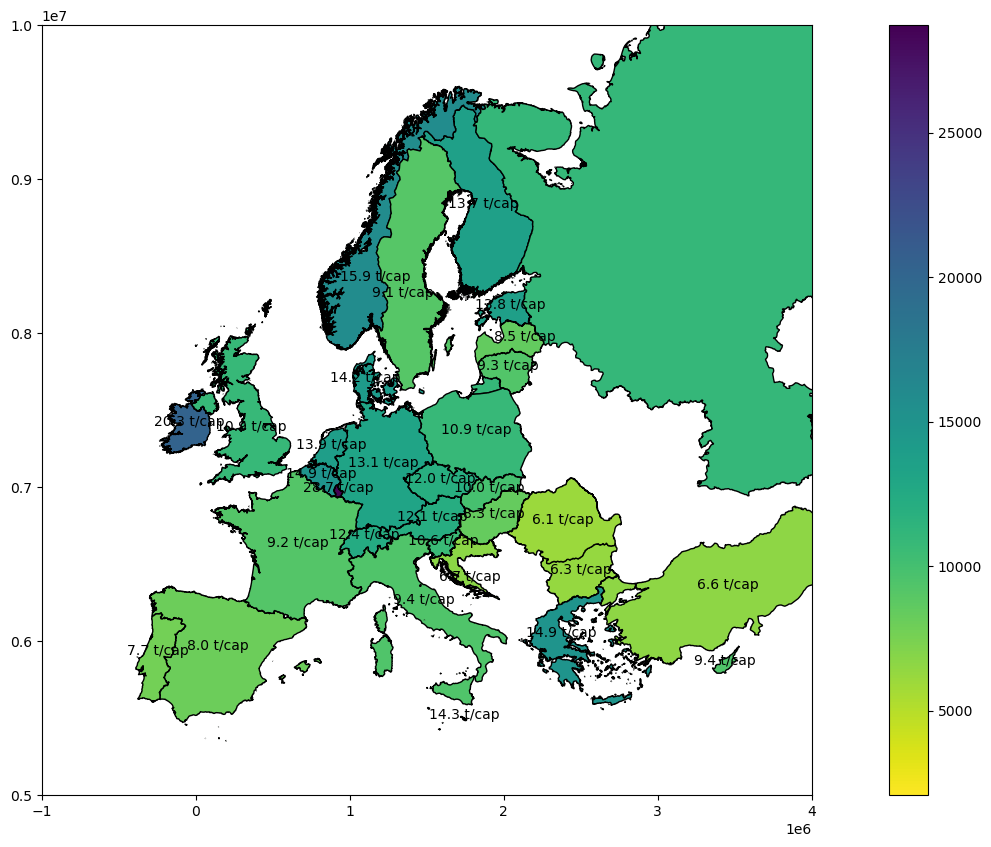

In [72]:
xmin, xmax = (-1e6,4e6)
ymin, ymax = (5e6, 10e6)

ax = df.plot(column=ind, cmap='viridis_r', edgecolor='k', legend=True, figsize=(20,10))
for idx, row in df.iterrows():
    xy = row['point'].coords[0]
    if (xmin < xy[0] < xmax) and (ymin < xy[1] < ymax) and not np.isnan(row[ind]):
        plt.annotate(s=f'{row[ind]/1000:.1f} t/cap',
                     xy=row['point'].coords[0],
                     horizontalalignment='center')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
